# Estimate baseline skill for LR & RF using the microphysics datasest
Improvement from the first scripts using code from NN_Emu_Example.ipynb



In [1]:
import sys
sys.path.append("/home/jmnugent/fv3net/workflows/emulation/")

import intake
import time
import os
import yaml
import tempfile

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import train_emulator as te

from matplotlib import colors
from cartopy import crs as ccrs
from fv3fit._shared.packer import ArrayPacker
from fv3viz import pcolormesh_cube, plot_cube_axes, mappable_var

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from loaders.mappers import open_phys_emu_training
from loaders.batches import batches_from_mapper


/home/jmnugent/miniconda3/envs/fv3net/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
train_data_path = "/mnt/disks/scratch/training/training-subsets/simple-phys-hybridedmf-w-microphysics-12day/"
test_data_path = "/mnt/disks/scratch/testing/validation-subsets/simple-phys-hybridedmf-w-microphysics-12day/"

# get the batches (if you want to use that method)
train_batches = te.get_subsampled_batches(train_data_path)
test_batches = te.get_subsampled_batches(test_data_path)

# get list of files
train_list_mphys = [train_data_path + f for f in os.listdir(train_data_path) if f.endswith('.nc')]
test_list_mphys = [test_data_path + f for f in os.listdir(test_data_path) if f.endswith('.nc')]


In [3]:
# multi index is dropped before netcdf save, so we have to add back in
# to get full spatial field
def _get_multi_idx(ds):
    coords_to_unstack = ["tile", "x", "y"]
    coords = [ds.coords[key].values for key in coords_to_unstack]
    multi_idx = pd.MultiIndex.from_tuples(zip(*coords), names=coords_to_unstack)
    
    ds = ds.reset_coords(coords_to_unstack, drop=True)
    return ds.assign_coords({"sample": multi_idx})


### Subselect variables, stack, and concatenate

##### Pick variables to include in the concatenated dataset

In [4]:
# list of the variables you want
input_vars = ["eastward_wind",
              "northward_wind", 
              "vertical_wind",
              "air_temperature",
              "pressure_thickness_of_atmospheric_layer",
              "specific_humidity",
              "cloud_water_mixing_ratio",
              ]

# list of the physics tendencies
all_phys_vars = ["tendency_of_air_temperature_due_to_fv3_physics",
                 "tendency_of_specific_humidity_due_to_fv3_physics",
                 "tendency_of_eastward_wind_due_to_fv3_physics",
                 "tendency_of_northward_wind_due_to_fv3_physics",
                 "tendency_of_cloud_water_mixing_ratio_due_to_fv3_physics",
                 "tendency_of_pressure_thickness_of_atmospheric_layer_due_to_fv3_physics",
                 ]

# list of the microphysics tendencies
micro_vars = ["tendency_of_specific_humidity_due_to_microphysics",
              "tendency_of_air_temperature_due_to_microphysics",
              ]

# shortened versions of the data variable names
short_names = ["u", "v", "w", "T", "dP", "qv", "qc",
               "T_phys", "qv_phys", "u_phys", "v_phys", "qc_phys", "dP_phys",
               "qv_micro", "T_micro"
              ]


In [13]:
# (technically not ALL)
all_vars = input_vars + all_phys_vars + micro_vars

# map the full name to the short name
shortname_dict = dict(zip(short_names, all_vars))

# pick variables
# using the dictionary just requires less typing
vars_to_include = [shortname_dict.get(key) for key in ["T", "dP", "qv", "qc", "qv_micro", "T_micro"]]


#### Process into one shortened/concatenated dataset
Also top 15 levels

In [14]:
%%time

timesteps_train = [[]]*len(train_list_mphys)
timesteps_test = [[]]*len(test_list_mphys)

for i in range(len(train_list_mphys)):
    timesteps_train[i] = xr.open_dataset(train_list_mphys[i])[vars_to_include].isel(z=slice(15, None))
    if i < len(test_list_mphys):
        timesteps_test[i] = xr.open_dataset(test_list_mphys[i])[vars_to_include].isel(z=slice(15, None))


CPU times: user 17.6 s, sys: 1.51 s, total: 19.1 s
Wall time: 5min 13s


In [15]:
%%time

# takes up to 11 min

ds_train = xr.concat(timesteps_train, dim='sample')
ds_test = xr.concat(timesteps_test, dim='sample')


CPU times: user 1min 41s, sys: 17.3 s, total: 1min 58s
Wall time: 11min 5s


In [16]:
stacked_train = ds_train.dropna(dim='sample')
stacked_test = ds_test.dropna(dim='sample')


In [17]:
# note: pack_names needs to get passed a list, not just a string
output_vars = [micro_vars[-1]]


In [18]:
# normalize the outputs
y_normalization = stacked_train[output_vars].std(dim="sample")

# use the ArrrayPacker class to convert into numpy arrays
X_packer = ArrayPacker(sample_dim_name="sample", pack_names=vars_to_include[:-2])

y_packer = ArrayPacker(sample_dim_name="sample", pack_names=output_vars)


In [19]:
# the packer needs to convert from dataset to array first:

X_train = X_packer.to_array(stacked_train)
y_train = y_packer.to_array(stacked_train)

X_test = X_packer.to_array(stacked_test)
y_test = y_packer.to_array(stacked_test)


In [20]:
# use StandardScaler object to normalize the y target vector
# (y-mean)/std --> contributions of different vertical levels are
# equally weighted in the loss function

y_scaler = StandardScaler().fit(y_train)
X_scaler = StandardScaler().fit(X_train)


### Linear regression

In [21]:
lr = LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)


In [22]:
%%time 

lr.fit(X_scaler.transform(X_train), y_scaler.transform(y_train))


CPU times: user 1min 40s, sys: 17 s, total: 1min 57s
Wall time: 28.4 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [23]:
y_predict_lr = y_scaler.inverse_transform(lr.predict(X_scaler.transform(X_test)))


#### Evaluate

In [24]:
mae_avg_lr = metrics.mean_absolute_error(y_test, y_predict_lr, multioutput='uniform_average')
mae_z_lr = metrics.mean_absolute_error(y_test, y_predict_lr, multioutput='raw_values')

rmse_avg_lr = np.sqrt(metrics.mean_squared_error(y_test, y_predict_lr, multioutput='uniform_average'))
rmse_z_lr = np.sqrt(metrics.mean_squared_error(y_test, y_predict_lr, multioutput='raw_values'))

r2_avg_lr = metrics.r2_score(y_test, y_predict_lr, multioutput='uniform_average')
r2_z_lr = metrics.r2_score(y_test, y_predict_lr, multioutput='raw_values')


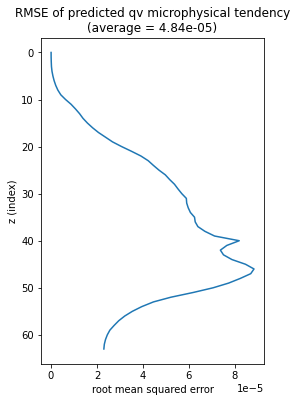

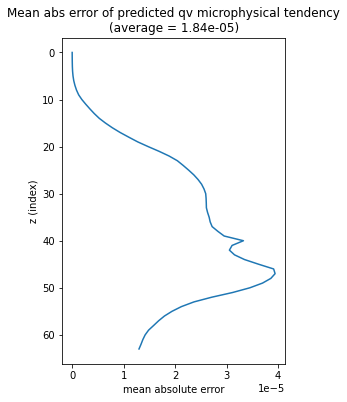

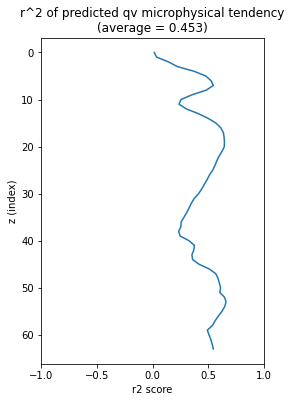

In [26]:
fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(rmse_z_lr, np.arange(0, len(rmse_z_lr)))
ax.set_ylabel('z (index)')
ax.set_xlabel('root mean squared error')
ax.set_title('RMSE of predicted qv microphysical tendency\n(average = {:.2e})'.format(rmse_avg_lr))
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(mae_z_lr, np.arange(0, len(mae_z_lr)))
ax.set_ylabel('z (index)')
ax.set_xlabel('mean absolute error')
ax.set_title('Mean abs error of predicted qv microphysical tendency\n(average = {:.2e})'.format(mae_avg_lr))
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(r2_z_lr, np.arange(0, len(r2_z_lr)))
ax.set_ylabel('z (index)')
ax.set_xlabel('r2 score')
ax.set_title('r^2 of predicted qv microphysical tendency\n(average = {:.3f})'.format(r2_avg_lr))
ax.set_xlim((-1, 1))
ax.invert_yaxis()
plt.show()


### Random forest

In [27]:
# rf = RandomForestRegressor(max_depth=8, n_estimators=5, n_jobs=-1)
rf = RandomForestRegressor(max_depth=8, n_estimators=50, n_jobs=-1)


In [28]:
%%time
# takes 2 hours

rf.fit(X_scaler.transform(X_train), y_scaler.transform(y_train))


CPU times: user 14h 27min 15s, sys: 7.63 s, total: 14h 27min 23s
Wall time: 1h 58min 17s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
y_predict_rf = y_scaler.inverse_transform(rf.predict(X_scaler.transform(X_test)))


#### Evaluate

In [31]:
mae_avg_rf = metrics.mean_absolute_error(y_test, y_predict_rf, multioutput='uniform_average')
mae_z_rf = metrics.mean_absolute_error(y_test, y_predict_rf, multioutput='raw_values')

rmse_avg_rf = np.sqrt(metrics.mean_squared_error(y_test, y_predict_rf, multioutput='uniform_average'))
rmse_z_rf = np.sqrt(metrics.mean_squared_error(y_test, y_predict_rf, multioutput='raw_values'))

r2_avg_rf = metrics.r2_score(y_test, y_predict_rf, multioutput='uniform_average')
r2_z_rf = metrics.r2_score(y_test, y_predict_rf, multioutput='raw_values')


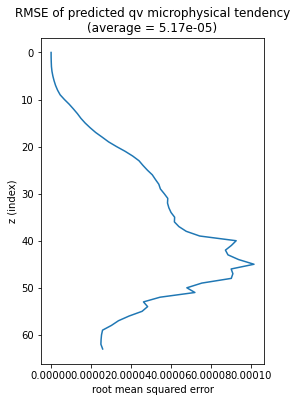

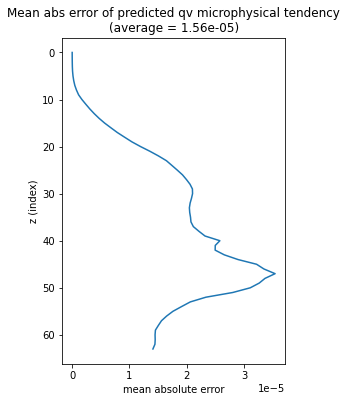

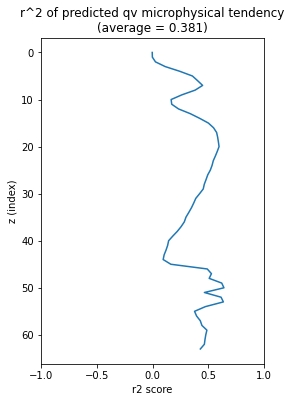

In [32]:
fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(rmse_z_rf, np.arange(0, len(rmse_z_rf)))
ax.set_ylabel('z (index)')
ax.set_xlabel('root mean squared error')
ax.set_title('RMSE of predicted qv microphysical tendency\n(average = {:.2e})'.format(rmse_avg_rf))
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(mae_z_rf, np.arange(0, len(mae_z_rf)))
ax.set_ylabel('z (index)')
ax.set_xlabel('mean absolute error')
ax.set_title('Mean abs error of predicted qv microphysical tendency\n(average = {:.2e})'.format(mae_avg_rf))
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(r2_z_rf, np.arange(0, len(r2_z_rf)))
ax.set_ylabel('z (index)')
ax.set_xlabel('r2 score')
ax.set_title('r^2 of predicted qv microphysical tendency\n(average = {:.3f})'.format(r2_avg_rf))
ax.set_xlim((-1, 1))
ax.invert_yaxis()
plt.show()
